# Дипломный проект Некрасов А.В.

## Predicting flight delays
Данные - https://www.kaggle.com/usdot/flight-delays
Описание - Сводная информация о количестве своевременных, задержанных, отмененных и измененных рейсов в США за 2015 год (5.8 млн записей)

### Задачи:

1 Найти аэропорт с минимальной задержкой вылета

2 Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport

3 Найти аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)

4 Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика),  в зависимости от аэропорта вылета  

#### Ход работ

Импортируем необходимые билиотеки

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#from google.colab import drive
#drive.mount('/content/drive')
import datetime, warnings, scipy
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('flights.csv', low_memory=False)

In [4]:
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,...,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,14721,0,0,0,...,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.252978,0.0,0.0,0.0,...,1.589822,1.805629,0.0,0.0,98.455357,81.72496,81.72496,81.72496,81.72496,81.72496


#### Data Definition

WHEELS_OFF Time - (Время взлета) The time point that the aircraft's wheels leave the ground.

WHEELS_ON Time - (Время приземления) The time point that the aircraft's wheels touch on the ground.

TAXI_OUT Time - (затраченное время на руление при вылете) The time duration elapsed between departure from the origin airport gate and wheels off.

TAXI_IN Time - (затраченное время на руление при прилете) The time duration elapsed between wheels-on and gate arrival at the destination airport.

AIR_TIME - (затраченное время на перелет) The time duration between wheels_off and wheels_on time.

#### Data Relationship

arrival_time = wheels_on + taxi_in

arrival_delay = arrival_time - scheduled_arrival

departure_time = wheels_off - taxi_out

departure_delay = departure_time - scheduled_departure

elapsed_time =air_time + taxi_in + taxi_out

air_time = wheels_on - wheels_off

In [5]:
# Оцениваем пропущенные данные и качество заполения по столбцам
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,CANCELLATION_REASON,5729195,1.544643
1,WEATHER_DELAY,4755640,18.275040
2,AIRLINE_DELAY,4755640,18.275040
3,SECURITY_DELAY,4755640,18.275040
4,AIR_SYSTEM_DELAY,4755640,18.275040
5,LATE_AIRCRAFT_DELAY,4755640,18.275040
6,ARRIVAL_DELAY,105071,98.194371
7,AIR_TIME,105071,98.194371
8,ELAPSED_TIME,105071,98.194371
9,TAXI_IN,92513,98.410178


In [6]:
# Аэропорты вылета и прилета закодированы в одном столбце разной кодировкой Цифровой и Буквенной 
# Имортируем библиотеки с кодировкой
# Приводим к строковому виду столбцы с кобировкой аэропортов

airport_id_df = pd.read_csv("L_AIRPORT_ID.csv")
airport_df = pd.read_csv("L_AIRPORT.csv")

df[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']] = df[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']].astype(str)
airport_id_df[['Code', 'Description']] = airport_id_df[['Code', 'Description']].astype(str)
airport_df[['Code', 'Description']] = airport_df[['Code', 'Description']].astype(str)


In [7]:
# Содиняем в единую библиотеку кодов аэропортов
concat_df = pd.concat([airport_id_df, airport_df], axis=0)
# Создаем словари для мапинга кодов аэропортов
airport_mapping = dict(zip(concat_df['Code'], concat_df['Description']))
airport_mapping_letter_code = dict(zip(airport_df['Description'], airport_df['Code']))

In [8]:
# Добавляем столбцы в датасете с единообразно кодировкой аэропортов прилета и вылита

df['Departure_Description'] = df['ORIGIN_AIRPORT'].map(airport_mapping)
df['Arrival_Description'] = df['DESTINATION_AIRPORT'].map(airport_mapping)
df['Departure_Marking'] = df['Departure_Description'].map(airport_mapping_letter_code)
df['Arrival_Marking'] = df['Arrival_Description'].map(airport_mapping_letter_code)

In [9]:
#Удаляем дублированные данные
variables_to_remove = ['Departure_Description', 'Arrival_Description', 'DESTINATION_AIRPORT' , 'ORIGIN_AIRPORT',
                      'CANCELLATION_REASON']

df.drop(variables_to_remove, axis = 1, inplace = True)

df.rename(columns = {'Departure_Marking' : 'ORIGIN_AIRPORT', 'Arrival_Marking' : 'DESTINATION_AIRPORT' }, inplace = True)

In [10]:
# Анализируем столбцы с задержками по разным причинам. 
df[['AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY']].value_counts()

AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  WEATHER_DELAY
15.0              0.0             0.0            0.0                  0.0              14074
16.0              0.0             0.0            0.0                  0.0              12735
17.0              0.0             0.0            0.0                  0.0              11146
18.0              0.0             0.0            0.0                  0.0              10235
19.0              0.0             0.0            0.0                  0.0               9074
                                                                                       ...  
12.0              0.0             17.0           66.0                 0.0                  1
                                                 58.0                 0.0                  1
                                                 53.0                 0.0                  1
                                                 49.0                 0.0      

In [11]:
#Nan заменяем на ноль
df[['AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY']] = df[['AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY']].fillna(0)

In [12]:
df[['DIVERTED','CANCELLED']].value_counts()
# Все переранправленые будут удалены при удалении NaN ARRIVAL_DELAY
# Все отмененные будут удалены при удалении NaN ARRIVAL_DELAY

DIVERTED  CANCELLED
0         0            5714008
          1              89884
1         0              15187
dtype: int64

In [13]:
df.to_csv("clean_flights.csv", index=False)

### 1 Найти аэропорт с минимальной задержкой вылета

In [ ]:
df = pd.read_csv('clean_flights.csv')

In [14]:
delay_airport_df = df[['ORIGIN_AIRPORT', 'DEPARTURE_DELAY']]

In [15]:
delay_airport_df.isnull().sum()

ORIGIN_AIRPORT         0
DEPARTURE_DELAY    86153
dtype: int64

In [16]:
delay_airport_df.dropna(inplace = True)

In [62]:
#аэропорт с минимальной задержкой вылета
min_delay_airport_df = delay_airport_df.groupby('ORIGIN_AIRPORT').min().sort_values(by = 'DEPARTURE_DELAY')
min_delay_airport_df.head(10)

,DEPARTURE_DELAY
ORIGIN_AIRPORT,
ADK,-82.0
PHX,-68.0
HSV,-61.0
APN,-56.0
GSO,-55.0
ATL,-52.0
YAK,-48.0
SBN,-48.0
TPA,-46.0


### 2 Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport

In [18]:
airlines_names = pd.read_csv('airlines.csv')
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()
companies_names = airlines_names.set_index('AIRLINE')['IATA_CODE'].to_dict()

In [19]:
lax_arrival_delay_df = df.loc[df['DESTINATION_AIRPORT'].isin(['LAX'])]
lax_arrival_delay_df = lax_arrival_delay_df[[ 'AIRLINE', 'ARRIVAL_DELAY']]

In [20]:
lax_arrival_delay_df['AIRLINE'] = lax_arrival_delay_df['AIRLINE'].map(abbr_companies)

In [21]:
lax_arrival_delay_df.dropna(inplace = True)

In [22]:
# функция, извлекающая статистические параметры из объекта groupby:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean(), 'median': group.median()}

# Создаем df со статистическими данными по каждой авиакомпании
global_stats = lax_arrival_delay_df['ARRIVAL_DELAY'].groupby(lax_arrival_delay_df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('mean', ascending=True)
global_stats

,min,max,count,mean,median
AIRLINE,,,,,
Hawaiian Airlines Inc.,-57.0,323.0,1673.0,-4.653317,-9.0
Alaska Airlines Inc.,-71.0,599.0,8969.0,-0.525700,-5.0
JetBlue Airways,-74.0,522.0,4424.0,-0.022152,-7.0
Delta Air Lines Inc.,-79.0,1045.0,27720.0,1.398882,-6.0
American Airlines Inc.,-73.0,1636.0,35619.0,2.122856,-7.0
US Airways Inc.,-65.0,309.0,3656.0,3.039387,-4.0
Virgin America,-81.0,651.0,12835.0,3.852513,-3.0
United Air Lines Inc.,-81.0,1185.0,29645.0,7.800304,-2.0
Southwest Airlines Co.,-58.0,502.0,40139.0,8.143601,0.0


In [23]:
#Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport
global_stats.head(1)

,min,max,count,mean,median
AIRLINE,,,,,
Hawaiian Airlines Inc.,-57.0,323.0,1673.0,-4.653317,-9.0


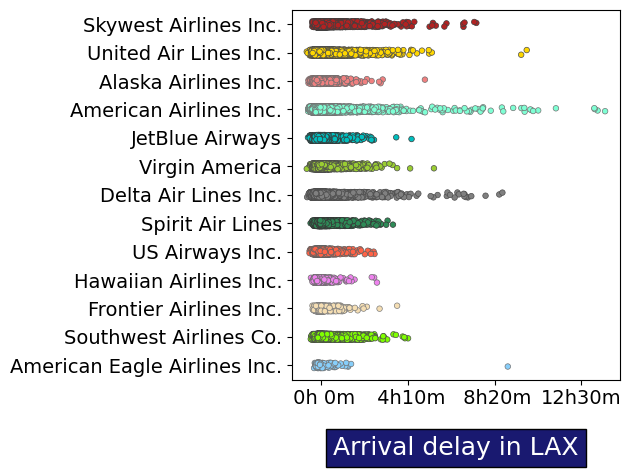

In [24]:
# striplot со всеми значениями задержек 

colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="ARRIVAL_DELAY", size = 4, palette = colors,
                    data=lax_arrival_delay_df, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Arrival delay in LAX', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3)

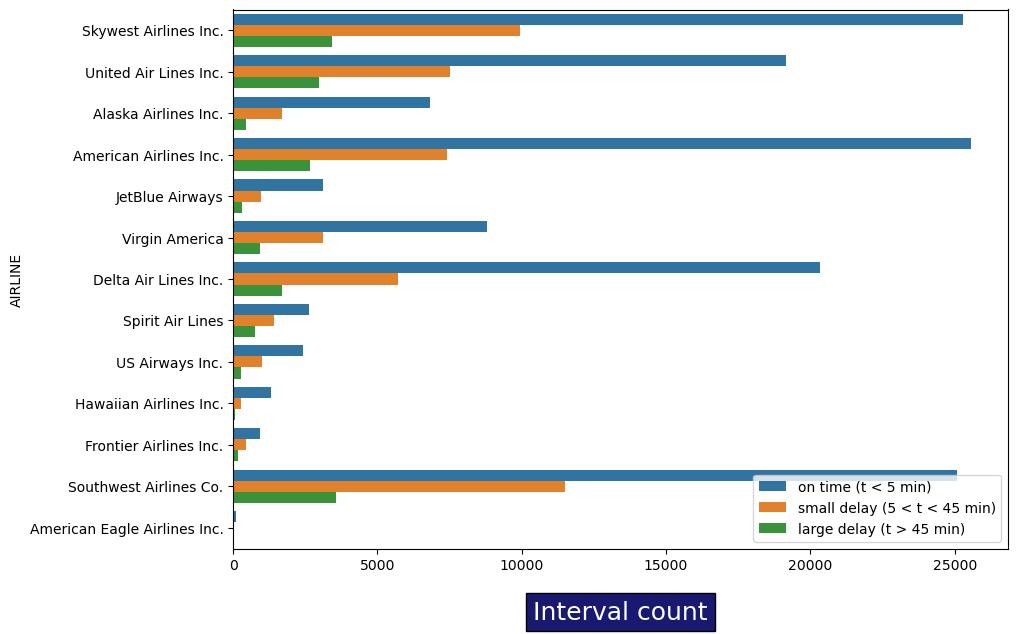

In [25]:
#_____________________________________________
# Функция группирующая задержки
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
lax_arrival_delay_df['DELAY_LEVEL'] = lax_arrival_delay_df['ARRIVAL_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=lax_arrival_delay_df)
#________________
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.xlabel('Interval count', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
plt.show()


### 3 Найти аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)

In [26]:
taxi_out_airport_df = df[['ORIGIN_AIRPORT', 'TAXI_OUT']]
taxi_in_airport_df = df[['DESTINATION_AIRPORT', 'TAXI_IN']]

taxi_out_airport_df.rename(columns = {'ORIGIN_AIRPORT' : 'AIRPORT', 'TAXI_OUT' : 'TAXI'}, inplace = True)
taxi_in_airport_df.rename(columns = {'DESTINATION_AIRPORT' : 'AIRPORT', 'TAXI_IN' : 'TAXI'}, inplace = True)

In [27]:
taxi_in_out_airport_df = pd.concat([taxi_out_airport_df, taxi_in_airport_df], axis=0)
taxi_in_out_airport_df.dropna()

,AIRPORT,TAXI
0,ANC,21.0
1,LAX,12.0
2,SFO,16.0
3,LAX,15.0
4,SEA,11.0
...,...,...
5819074,BOS,4.0
5819075,PSE,3.0
5819076,SJU,8.0
5819077,SJU,3.0


In [63]:
#аэропорт, где самолёты проводят больше всего времени на рулении
taxi_in_out_airport_df.groupby('AIRPORT').mean().sort_values(by = 'TAXI', ascending = False).head(10)

,TAXI
AIRPORT,
LGA,17.788691
JFK,17.745088
ORD,16.365225
EWR,14.879636
CLT,14.645538
DFW,14.472217
LAX,14.303271
PHL,14.130344
MIA,13.698436


In [29]:
lga_taxi_in_out_airport_df = taxi_in_out_airport_df.loc[taxi_in_out_airport_df['AIRPORT'].isin(['LGA'])]

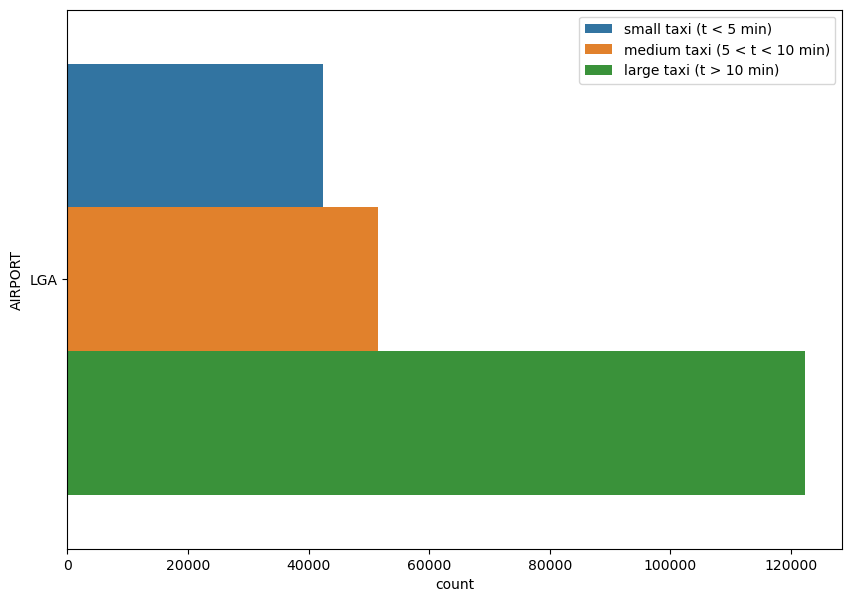

In [30]:
#_____________________________________________
# Функция определяющая как группируется время на руление
taxi_type = lambda x:((0,1)[x > 5],2)[x > 10]
lga_taxi_in_out_airport_df['TAXI_LEVEL'] = lga_taxi_in_out_airport_df['TAXI'].apply(taxi_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRPORT", hue='TAXI_LEVEL', data=lga_taxi_in_out_airport_df)
#________________

L = plt.legend()
L.get_texts()[0].set_text('small taxi (t < 5 min)')
L.get_texts()[1].set_text('medium taxi (5 < t < 10 min)')
L.get_texts()[2].set_text('large taxi (t > 10 min)')
plt.show()

### 4 Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика), в зависимости от аэропорта вылета

При прогнозировании задержек рейсов обычно рекомендуется исключать отмененные и измененные рейсы из набора данных, используемого для обучения и прогнозирования. Это связано с тем, что для отмененных рейсов нельзя предсказать значение задержки, а для рейсов с измененным маршрутом могут быть разные факторы, влияющие на время задержки.

Включение отмененных рейсов в набор данных может внести шум и повлиять на точность прогнозов. Более того, если целью является прогнозирование задержек в оперативных целях, включение отмененных рейсов может не дать значимой информации.

Точно так же перенаправленные рейсы могут иметь разные аэропорты вылета и прибытия, что может существенно повлиять на характер задержек. Причины изменения маршрута, такие как погодные условия или эксплуатационные ограничения, также могут отличаться от обычных рейсов. Включение перенаправленных рейсов в набор данных может привести к необъективным прогнозам и может неточно отражать типичные модели задержек.


In [31]:
preprocessed_flights_df = pd.read_csv('clean_flights.csv')

<Axes: >

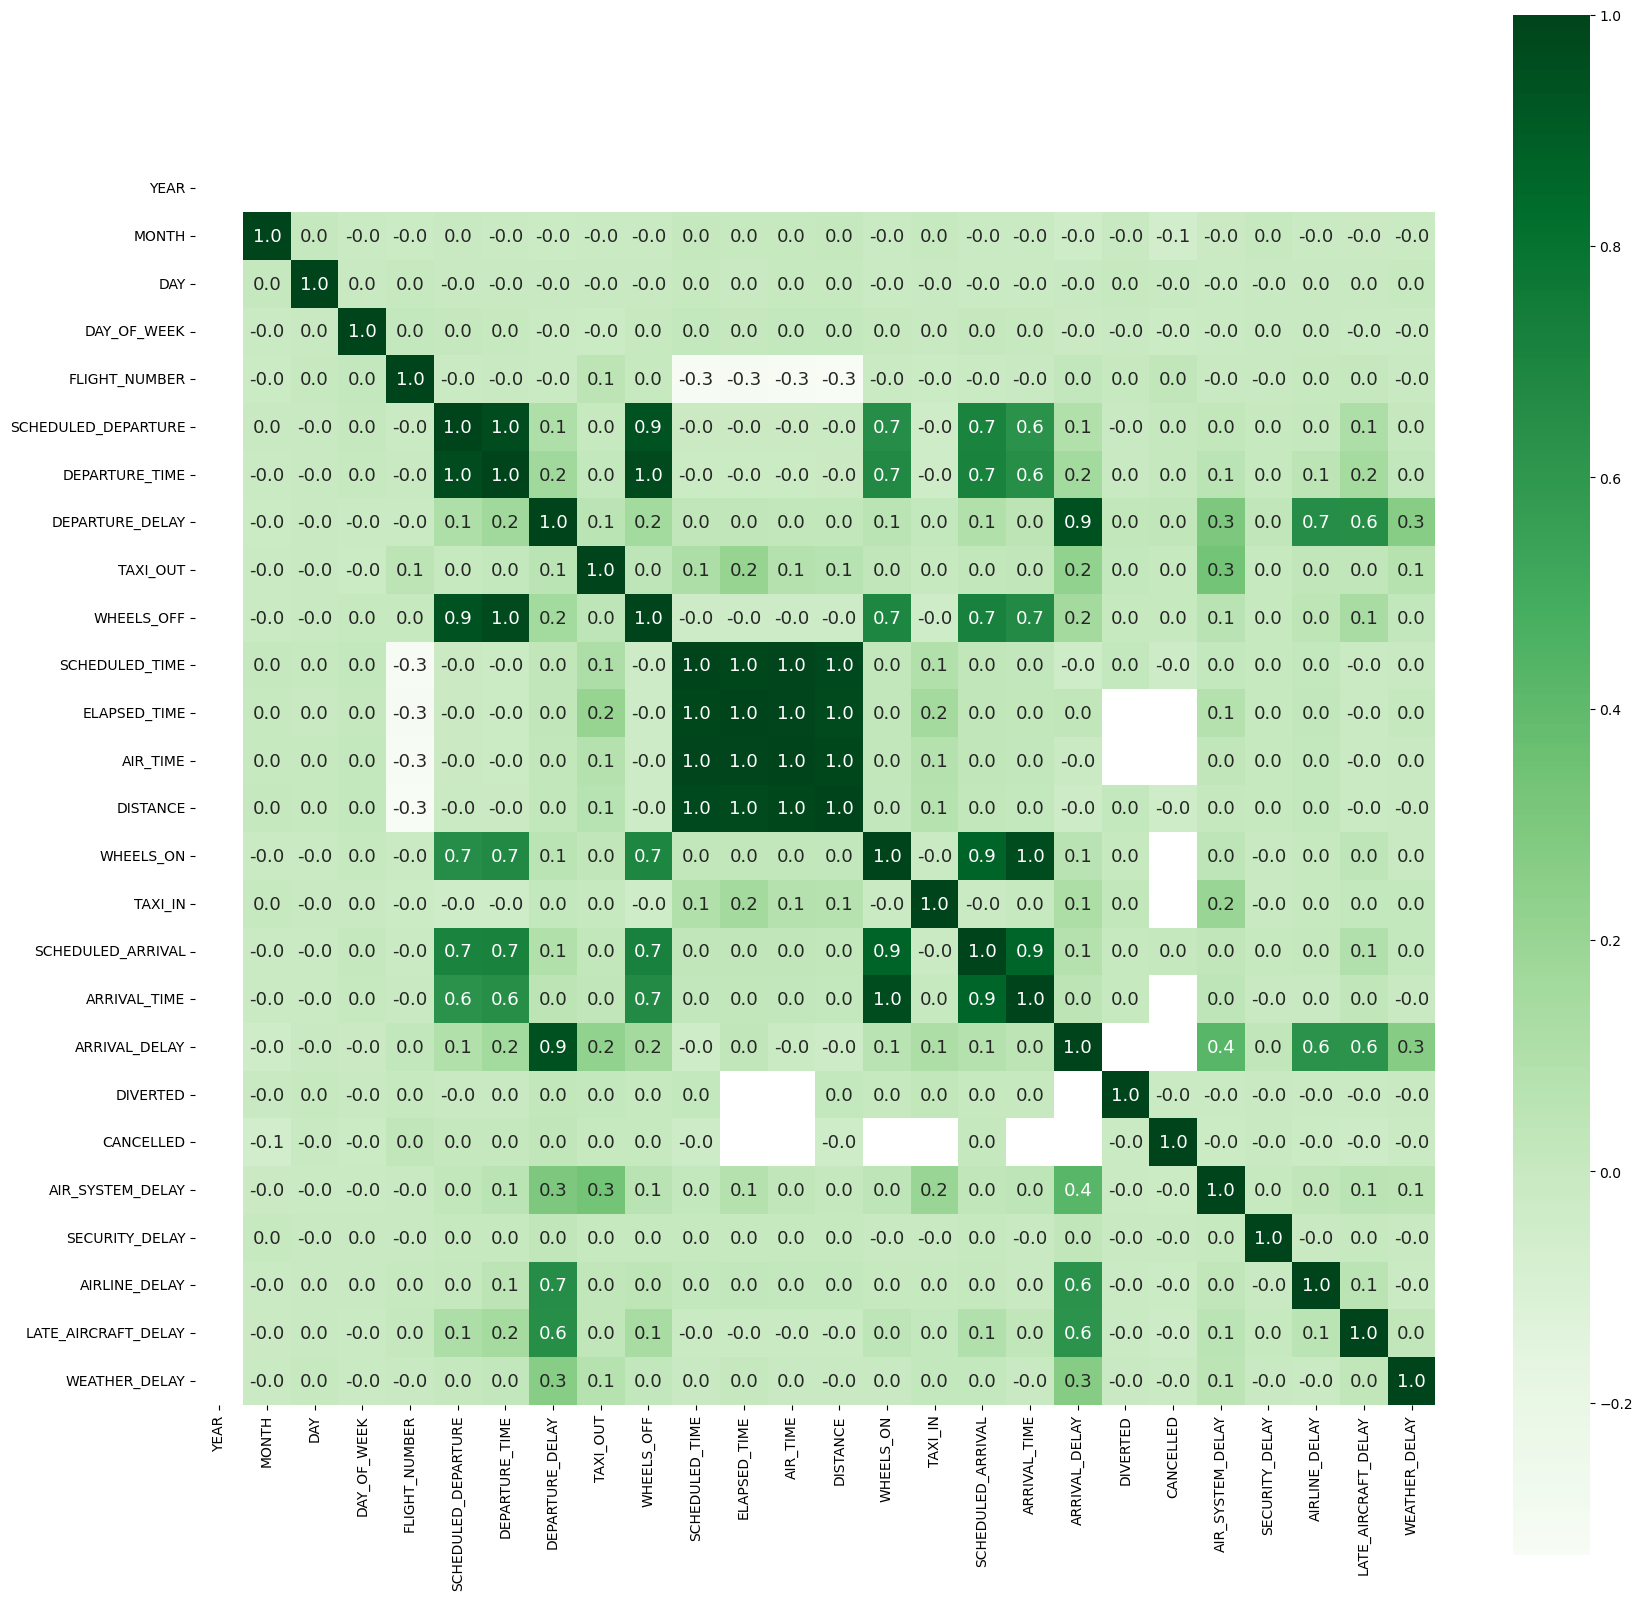

In [32]:
corr = df.corr()

# Plotting the heatmap of correlation between features
plt.figure(figsize=(20,20))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':13}, cmap='Greens')

#### Выводы из исследования корреляции:
- маркировку аэропортов и авиакомпаний нужно переводить в числовую и отдельно изучать
- сформировано несколько блоков мультиколлениарных фичей. 
- из этих групп выберем те которые подходят под задачу, а именно только те данные которые мы знаем при планировании перелета 
    *  ARRIVAL_DELAY - Прогнозируемая величина
    1. SCHEDULED_DEPARTURE
    2. DISTANCE
    3. SCHEDULED_ARRIVAL
    4. AIRLINE - 
    5. DESTINATION_AIRPORT
- также исключаем из модели отмененные и измененные рейсы.  Для отмененных рейсов нельзя предсказать значение задержки, а для рейсов с измененным маршрутом могут быть разные факторы, влияющие на время задержки. Причины изменения маршрута, такие как погодные условия или эксплуатационные ограничения, также могут отличаться от обычных рейсов. Включение перенаправленных рейсов в набор данных может привести к необъективным прогнозам и может неточно отражать типичные модели задержек.
   

In [33]:
preprocessed_flights_df = df[['ORIGIN_AIRPORT', 'SCHEDULED_DEPARTURE', 'DISTANCE', 'SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY', 'AIRLINE', 'DESTINATION_AIRPORT']].copy()

In [34]:
#Удаляем строки с пустыми знчениями
preprocessed_flights_df.dropna(inplace = True)

In [140]:
# сохраняем подготовленные данные в CSV файл 
preprocessed_flights_df.to_csv("preprocessed_flights.csv", index=False)

In [35]:
airports_data = pd.read_csv("airports.csv")
airports_data.dropna(inplace = True)

In [36]:
airports_data.to_csv("airports.csv", index=False)

In [ ]:
# Загружаем подготовленные данные
#df = pd.read_csv("preprocessed_flights.csv")

In [37]:
# Выбираем аэропорт вылета для анализа 
origin_airport = 'JFK'  

# фольтруем датасет по аэропорту вылета
df_origin = preprocessed_flights_df[preprocessed_flights_df['ORIGIN_AIRPORT'] == origin_airport]

In [38]:
df_origin

,ORIGIN_AIRPORT,SCHEDULED_DEPARTURE,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,AIRLINE,DESTINATION_AIRPORT
97,JFK,535,1598,1020,19.0,B6,SJU
120,JFK,545,1089,850,69.0,AA,MIA
123,JFK,545,1576,1026,-19.0,B6,BQN
238,JFK,600,1028,858,-22.0,B6,PBI
243,JFK,600,944,851,-19.0,B6,MCO
...,...,...,...,...,...,...,...
5818939,JFK,2250,301,13,13.0,B6,BUF
5818980,JFK,2312,187,16,-15.0,B6,BOS
5819075,JFK,2359,1617,446,-16.0,B6,PSE
5819076,JFK,2359,1598,440,-8.0,B6,SJU


In [39]:
df_encoded = df_origin[['DESTINATION_AIRPORT', 'AIRLINE']].copy()
df_encoded = pd.get_dummies(df_encoded, columns=['DESTINATION_AIRPORT', 'AIRLINE' ])

In [40]:
df_encoded

,DESTINATION_AIRPORT_ABQ,DESTINATION_AIRPORT_ACK,DESTINATION_AIRPORT_ATL,DESTINATION_AIRPORT_BNA,DESTINATION_AIRPORT_BOS,DESTINATION_AIRPORT_BQN,DESTINATION_AIRPORT_BSM,DESTINATION_AIRPORT_BTV,DESTINATION_AIRPORT_BUF,DESTINATION_AIRPORT_BUR,...,DESTINATION_AIRPORT_TPA,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_HA,AIRLINE_MQ,AIRLINE_UA,AIRLINE_US,AIRLINE_VX
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
120,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
123,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818939,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
5818980,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5819075,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5819076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [41]:
df_encoded = pd.concat([df_origin, df_encoded], axis=1)

In [42]:
df_encoded

,ORIGIN_AIRPORT,SCHEDULED_DEPARTURE,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,AIRLINE,DESTINATION_AIRPORT,DESTINATION_AIRPORT_ABQ,DESTINATION_AIRPORT_ACK,DESTINATION_AIRPORT_ATL,...,DESTINATION_AIRPORT_TPA,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_HA,AIRLINE_MQ,AIRLINE_UA,AIRLINE_US,AIRLINE_VX
97,JFK,535,1598,1020,19.0,B6,SJU,0,0,0,...,0,0,0,1,0,0,0,0,0,0
120,JFK,545,1089,850,69.0,AA,MIA,0,0,0,...,0,1,0,0,0,0,0,0,0,0
123,JFK,545,1576,1026,-19.0,B6,BQN,0,0,0,...,0,0,0,1,0,0,0,0,0,0
238,JFK,600,1028,858,-22.0,B6,PBI,0,0,0,...,0,0,0,1,0,0,0,0,0,0
243,JFK,600,944,851,-19.0,B6,MCO,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818939,JFK,2250,301,13,13.0,B6,BUF,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5818980,JFK,2312,187,16,-15.0,B6,BOS,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5819075,JFK,2359,1617,446,-16.0,B6,PSE,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5819076,JFK,2359,1598,440,-8.0,B6,SJU,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [43]:
features = df_encoded.columns.values.tolist()
features_train_test = df_encoded.columns.values.tolist()

In [44]:
features_to_remove = [
 'AIRLINE',
 'ORIGIN_AIRPORT',
'ARRIVAL_DELAY']

In [45]:
 features_to_remove_1 = [
 'AIRLINE',
 'ORIGIN_AIRPORT',
'DESTINATION_AIRPORT',
 'ARRIVAL_DELAY']

In [46]:
for feature_id in features_to_remove:
    # Проходим по списку и удаляем.
    features.remove(feature_id)

for feature_id in features_to_remove_1:
    # Проходим по списку и удаляем.
    features_train_test.remove(feature_id)


In [47]:
# Делим на тестовую и обучающую части 
X = df_encoded[features]
y = df_encoded['ARRIVAL_DELAY']
X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
X_train = X_train_all[features_train_test]
X_test = X_test_all[features_train_test]

In [ ]:
# Тренируем линейную регрессию
#linear_model = LinearRegression()
#linear_model.fit(X_train, y_train)
# Делаем предсказание на тестовом сете
#y_pred_linear = linear_model.predict(X_test)

# Рассчитываем  RMSE
#rmse = mean_squared_error(y_test, y_pred_linear, squared=False)

In [ ]:
# Обучаем модель случайных деревьев
#rf_model = RandomForestRegressor()
#rf_model.fit(X_train, y_train)
#y_pred_rf = rf_model.predict(X_test)

# Рассчитываем RMSE
#rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

In [ ]:
# Обучаем гдадиент бустинг модель 
#gb_model = GradientBoostingRegressor()
#gb_model.fit(X_train, y_train)
#y_pred_gb = gb_model.predict(X_test)
# Рассчитываем RMSE
#rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)

In [49]:
# Тренируем линейную регрессию
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Обучаем модель случайных деревьев
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Обучаем гдадиент бустинг модель 
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Рассчитываем RMSE по каждой модели
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)

# Печатаем RMSE для каждой модели
print("Linear Regression RMSE:", rmse_linear)
print("Random Forest RMSE:", rmse_rf)
print("Gradient Boosting RMSE:", rmse_gb)

# Объедините значения RMSE с именами моделей для сортировки
rmse_values = [rmse_linear, rmse_rf, rmse_gb]
model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
rmse_by_model = list(zip(model_names, rmse_values))


Linear Regression RMSE: 44.27876349623071
Random Forest RMSE: 44.60421569585116
Gradient Boosting RMSE: 44.15506592665855


In [50]:
arrival_data = pd.DataFrame({'DESTINATION_AIRPORT': X_test_all['DESTINATION_AIRPORT'], 'ARRIVAL_DELAY_TEST': y_test, 'ARRIVAL_DELAY_PRED_LINEAR':y_pred_linear, 'ARRIVAL_DELAY_PRED_RF': y_pred_rf, 'ARRIVAL_DELAY_PRED_GB': y_pred_gb })

In [51]:
arrival_data

,DESTINATION_AIRPORT,ARRIVAL_DELAY_TEST,ARRIVAL_DELAY_PRED_LINEAR,ARRIVAL_DELAY_PRED_RF,ARRIVAL_DELAY_PRED_GB
4625897,TPA,42.0,-1.290822,20.264239,-2.087188
4672065,LAX,-14.0,-9.173725,-11.544937,-6.669773
3355654,SLC,63.0,9.920669,6.521815,4.797513
1952845,BOS,20.0,1.826009,-1.261311,-0.195509
2247045,CLT,-1.0,3.002198,1.752155,1.434387
...,...,...,...,...,...
1816725,SFO,-40.0,-0.164960,6.279102,-1.153489
2670553,MCO,-29.0,17.003900,0.164090,21.115658
4747309,RDU,130.0,7.839639,-3.054308,9.044085
257099,BOS,-17.0,9.951726,14.730098,9.098535


In [52]:
# Гуппируем arrival_data по 'ARRIVAL_AIRPORT'
grouped_data = arrival_data.groupby('DESTINATION_AIRPORT')

In [53]:
# формируем пустые RMSE списки
rmse_list_linear = []
rmse_list_rf = []
rmse_list_gb= []

# Итерация по группам и вычисление RMSE для каждой группы
for group_name, group_data in grouped_data:
    group_indices = group_data.index
    group_y_test = group_data['ARRIVAL_DELAY_TEST']
    group_y_pred_linear = group_data['ARRIVAL_DELAY_PRED_LINEAR']
    group_y_pred_rf = group_data['ARRIVAL_DELAY_PRED_RF']
    group_y_pred_gb = group_data['ARRIVAL_DELAY_PRED_GB']
    rmse_linear = mean_squared_error(group_y_test, group_y_pred_linear, squared=False)
    rmse_rf= mean_squared_error(group_y_test, group_y_pred_rf, squared=False)
    rmse_gb = mean_squared_error(group_y_test, group_y_pred_gb, squared=False)
    rmse_list_linear.append((group_name, rmse_linear))
    rmse_list_rf.append((group_name, rmse_rf))
    rmse_list_gb.append((group_name, rmse_gb))


In [54]:
# Сортируем значения RMSE в порядке возрастания
rmse_list_linear.sort(key=lambda x: x[1])

# Выбераем 3 лучших аэропорта прибытия с минимальным RMSE
top_3_airports_linear = [airport for airport, _ in rmse_list_linear[:3]]


# Сортируем значения RMSE в порядке возрастания
rmse_list_rf.sort(key=lambda x: x[1])

# Выбераем 3 лучших аэропорта прибытия с минимальным RMSE
top_3_airports_rf = [airport for airport, _ in rmse_list_rf[:3]]

# Сортируем значения RMSE в порядке возрастания
rmse_list_gb.sort(key=lambda x: x[1])

# Выбераем 3 лучших аэропорта прибытия с минимальным RMSE
top_3_airports_gb = [airport for airport, _ in rmse_list_gb[:3]]


In [55]:
print(f'Топ 3 аэропортпа по прогнозу линейной регрессии: {top_3_airports_linear}')
print(f'Топ 3 аэропортпа по прогнозу модели Random Forest: {top_3_airports_rf}')
print(f'Топ 3 аэропортпа по прогнозу модели Gradient Boosting: {top_3_airports_gb}')

Топ 3 аэропортпа по прогнозу линейной регрессии: ['PSP', 'HYA', 'JAC']
Топ 3 аэропортпа по прогнозу модели Random Forest: ['JAC', 'PSP', 'HYA']
Топ 3 аэропортпа по прогнозу модели Gradient Boosting: ['JAC', 'PSP', 'HYA']


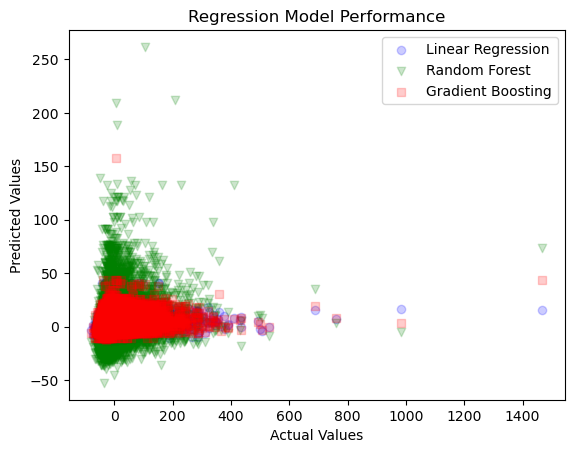

In [56]:
plt.scatter(y_test, y_pred_linear, color='blue', alpha=0.2, marker="o", label='Linear Regression')
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.2, marker="v",  label='Random Forest')
plt.scatter(y_test, y_pred_gb, color='red',alpha=0.2, marker="s", label='Gradient Boosting')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Regression Model Performance')
plt.legend()
plt.show()

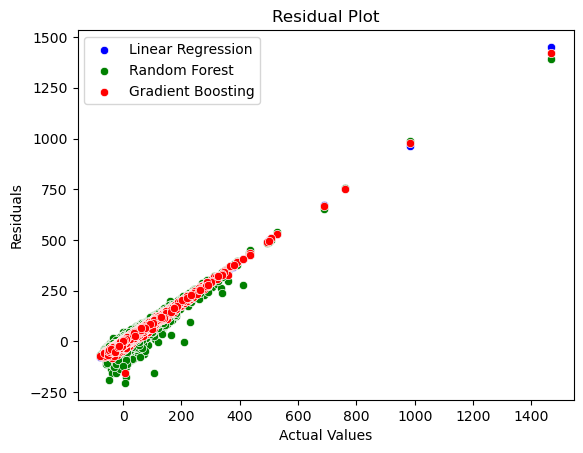

In [57]:
# Рассчитыеваем разность
residuals_linear = y_test - y_pred_linear
residuals_rf = y_test - y_pred_rf
residuals_gb = y_test - y_pred_gb

# Создаем DataFrame с фактическими значениями и остатками
residuals_df = pd.DataFrame({'Actual': y_test, 'Linear Regression': residuals_linear, 'Random Forest': residuals_rf, 'Gradient Boosting': residuals_gb})

# строим графики для разности по разным моделям
sns.scatterplot(x='Actual', y='Linear Regression', data=residuals_df, color='blue', label='Linear Regression')
sns.scatterplot(x='Actual', y='Random Forest', data=residuals_df, color='green', label='Random Forest')
sns.scatterplot(x='Actual', y='Gradient Boosting', data=residuals_df, color='red', label='Gradient Boosting')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.show()

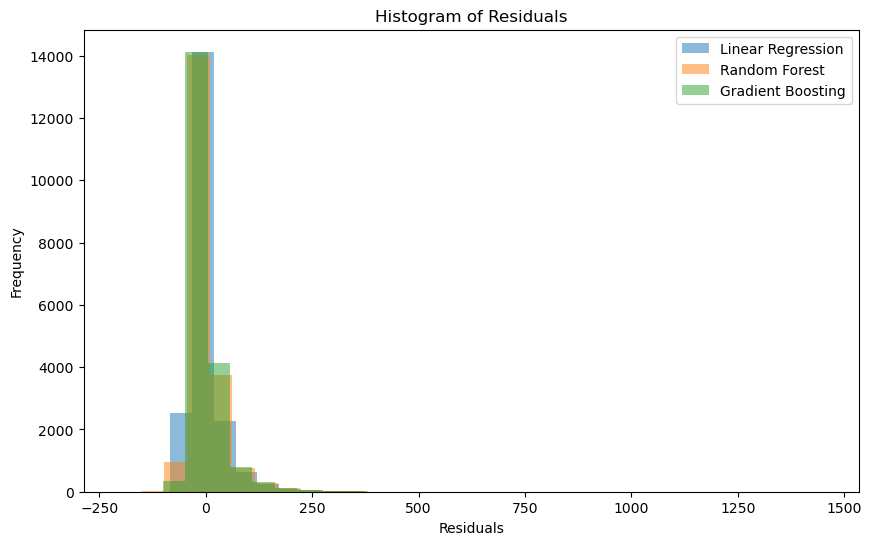

In [58]:
plt.figure(figsize=(10, 6))
plt.hist(residuals_linear, bins=30, alpha=0.5, label='Linear Regression')
plt.hist(residuals_rf, bins=30, alpha=0.5, label='Random Forest')
plt.hist(residuals_gb, bins=30, alpha=0.5, label='Gradient Boosting')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.legend()
plt.show()

In [102]:
rmse_list_linear_df = pd.DataFrame(rmse_list_linear).sort_values(by = 1)
rmse_list_rf_df = pd.DataFrame(rmse_list_rf).sort_values(by = 1)
rmse_list_gb_df = pd.DataFrame(rmse_list_gb).sort_values(by = 1)

In [60]:
rmse_data = pd.DataFrame({'DESTINATION_AIRPORT': rmse_list_linear_df[0], 'RMSE_LINEAR': rmse_list_linear_df[1], 'RMSE_RF': rmse_list_rf_df[1], 'RMSE_GB': rmse_list_gb_df[1]  })

In [64]:
rmse_data.head(10)

,DESTINATION_AIRPORT,RMSE_LINEAR,RMSE_RF,RMSE_GB
0,PSP,11.669887,3.868663,4.785524
1,HYA,16.088513,12.711894,9.708580
2,JAC,19.749579,16.245462,16.072557
3,MVY,22.223258,22.332082,23.112534
4,SRQ,23.184604,24.668030,23.319593
5,SMF,25.569517,25.841453,25.505532
6,SAT,27.765413,29.886704,29.200587
7,PIT,28.203222,31.457151,29.821951
8,SJC,30.116159,31.884678,30.268478
9,BWI,30.583126,31.947205,30.814839
